https://www.kaggle.com/code/yassineghouzam/titanic-top-4-with-ensemble-modeling/notebook

## 1. Introduction

- Feature analysis
- Feature engineering
- Modeling

In [214]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')

from collections import Counter
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

# 2. Load and check data

### 2.1 Load data

In [215]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [216]:
train = pd.read_csv('/content/drive/MyDrive/Data/캐글 실습 필사/Titanic/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Data/캐글 실습 필사/Titanic/test.csv')
IDTest = test['PassengerId']

In [217]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 2.2 Outlier detection

In [218]:
def detect_outliers(df, n, features):
  outlier_indices = []
  
  for col in features:
    Q1 = np.percentile(df[col],25)
    Q3 = np.percentile(df[col],75)
    IQR = Q3 - Q1
    outlier_step = 1.5 * IQR
    outlier_list_col = df[(df[col]<Q1-outlier_step)|(df[col]>Q3+outlier_step)].index
    outlier_indices.extend(outlier_list_col)
  outlier_indices = Counter(outlier_indices) # 리스트에 넣음
  multiple_outliers = list(k for k, v in outlier_indices.items() if v>n)

  return multiple_outliers

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train, 2, ["Age","SibSp","Parch","Fare"])

In [219]:
Outliers_to_drop # 10 outliners

[27, 88, 159, 180, 201, 324, 341, 792, 846, 863]

In [220]:
train.loc[Outliers_to_drop]
# 28, 89, 342 passenger have an high Ticket Fare
# The 7 others have very high values of SibSP.

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [221]:
# Drop outliers
train = train.drop(Outliers_to_drop, axis=0).reset_index(drop=True)

## 2.3 joining train and test set

In [222]:
train_len = len(train)
dataset = pd.concat([train, test], axis=0).reset_index(drop=True)

## 2.4 check for null and missing values

In [223]:
dataset = dataset.fillna(np.nan)
dataset.isnull().sum()
# Age, Cabin에 NaN이 너무 많음.

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

In [224]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [225]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [226]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [227]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


# 3. Feature analysis

## 3.1 Numerical values

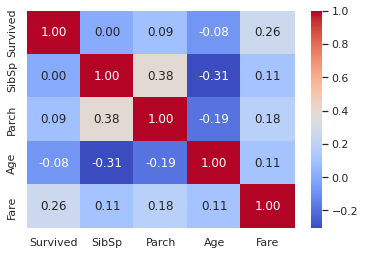

In [228]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived 
g = sns.heatmap(train[["Survived","SibSp","Parch","Age","Fare"]].corr(), annot=True, fmt=".2f", cmap='coolwarm')
# Survived와 상관관계를 갖는 변수는 Fare, but 다른 변수들이 연관되어 있지 않다는 것은 아님.

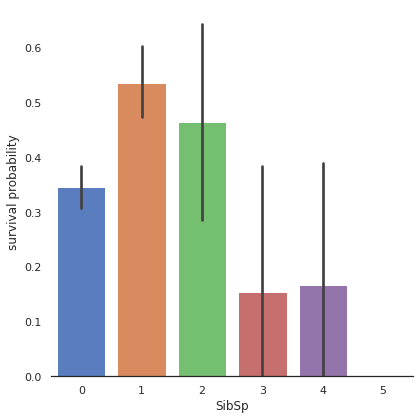

In [229]:
# Sibsp
g = sns.factorplot(x='SibSp', y='Survived', data=train, kind='bar', size=6, palette='muted')
# facetplot: y값의 평균 그래프
g.despine(left=True) # 왼쪽축 테두리 제거
g = g.set_ylabels('survival probability')

# 형제가 많을수록 생존할 확률이 낮음.

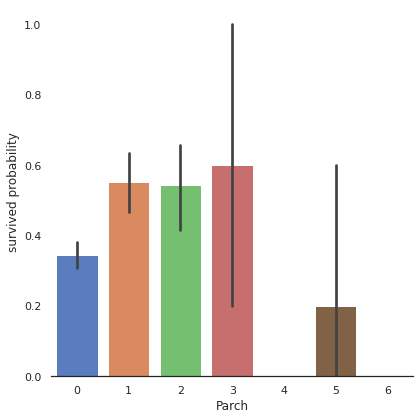

In [230]:
# Parch
g = sns.factorplot(x='Parch', y='Survived', data=train, kind='bar', size=6, palette='muted')
g.despine(left=True)
g = g.set_ylabels("survived probability")
# small family가 더 살아남을 확률이 높음.

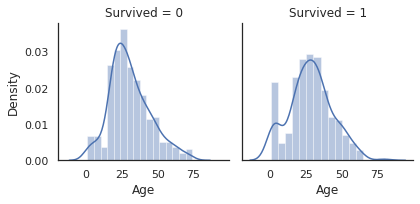

In [231]:
# Age
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, 'Age')
# 어린 나이 승객들이 살아남을 확률이 더 높음.

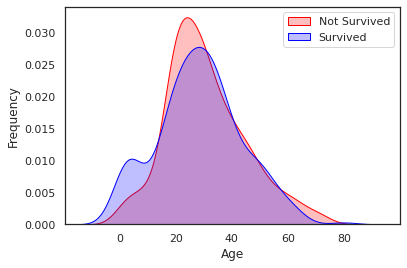

In [232]:
g = sns.kdeplot(train['Age'][(train['Survived']==0) & (train['Age'].notnull())], color='Red', shade=True)
g = sns.kdeplot(train['Age'][(train['Survived']==1) & (train['Age'].notnull())], ax=g, color='Blue', shade=True)
g.set_xlabel('Age')
g.set_ylabel('Frequency')
g = g.legend(['Not Survived', 'Survived'])

In [233]:
# Fare 결측치 확인
dataset['Fare'].isnull().sum()

1

In [234]:
# 결측치 채우기
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())

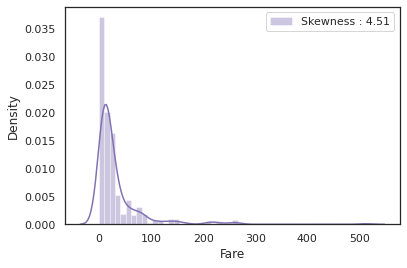

In [235]:
# Fare distribution
g = sns.distplot(dataset['Fare'], color='m', label='Skewness : %.2f' %(dataset['Fare'].skew()))
g = g.legend(loc='best')
# skewed 분포 -> 로그 변환

In [236]:
# 로그 변환
dataset['Fare'] = dataset['Fare'].map(lambda x: np.log(x) if x>0 else 0)

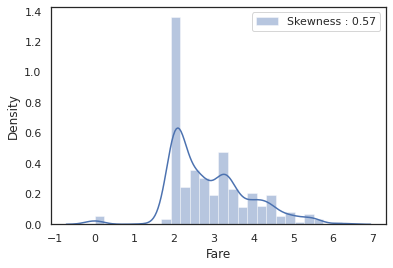

In [237]:
g = sns.distplot(dataset['Fare'], color='b', label='Skewness : %.2f' %(dataset['Fare'].skew()))
g = g.legend(loc='best')
# skewness가 해소됨.

## 3.2 Categorical values

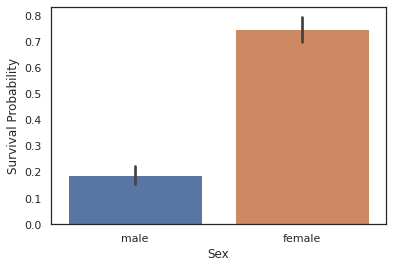

In [238]:
# Sex
g = sns.barplot(x="Sex",y="Survived",data=train)
g = g.set_ylabel("Survival Probability")

In [239]:
train[['Sex', 'Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


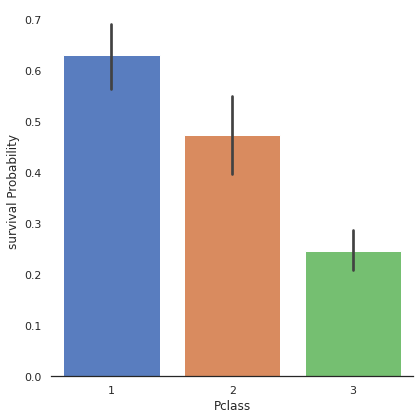

In [240]:
# Pclass
g = sns.factorplot(x='Pclass', y='Survived', data=train, kind='bar', size=6, palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival Probability')

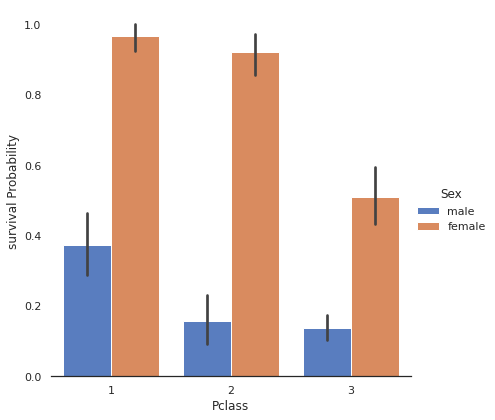

In [241]:
g = sns.factorplot(x='Pclass', y='Survived', hue='Sex', data=train, size=6, kind='bar', palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival Probability')

In [242]:
# Embarked 결측치 확인
dataset['Embarked'].isnull().sum()

2

In [243]:
dataset['Embarked'].mode()[0]

'S'

In [244]:
# 결측치 채우기
dataset['Embarked'] = dataset['Embarked'].fillna('S')

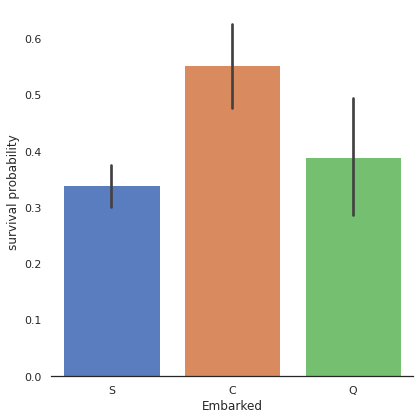

In [245]:
g = sns.factorplot(x='Embarked', y='Survived', data=train, size=6, kind='bar', palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')
# Cherbourg(C)에서 온 승객들의 생존율이 높음.

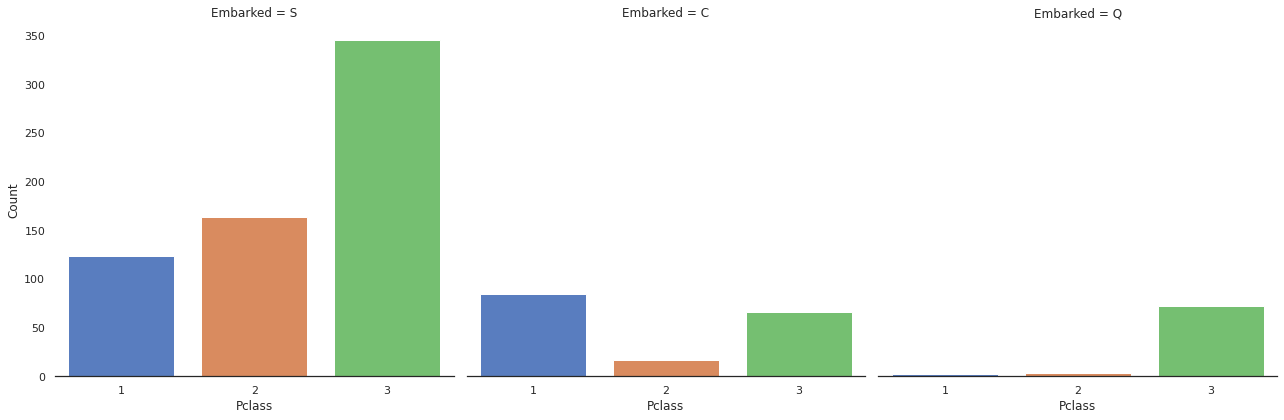

In [246]:
# 가설: Proportion of first class passengers is higher for those who came from Cherbourg than Queenstown (Q), Southampton (S).
# Pclass distribution vs Embarked
g = sns.factorplot('Pclass', col='Embarked', data=train, size=6, kind='count', palette='muted')
g.despine(left=True)
g = g.set_ylabels('Count')
# Cherbourg 승객들은 거의 1등급에 많이 분포

# 4. Filling missing Values

## 4.1 Age

In [247]:
dataset['Age'].isnull().sum()

256

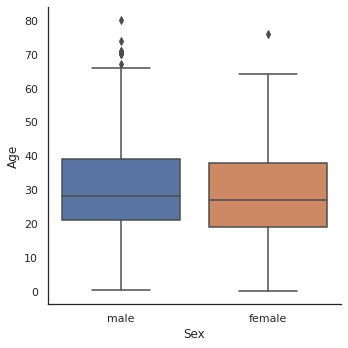

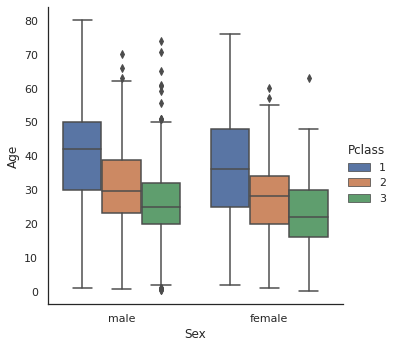

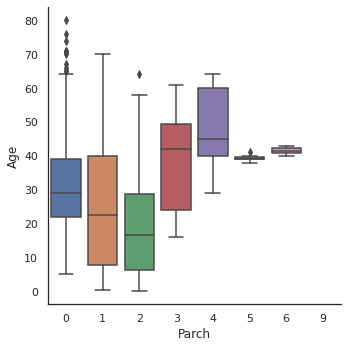

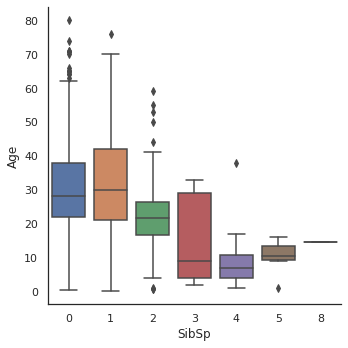

In [248]:
# Age 변수는 생존율에 영향을 미치므로 이를 고려하여 결측치를 대체해야 함.
g = sns.factorplot(y='Age', x='Sex', data=dataset, kind='box')
# Sex is not informative to predict Age.
g = sns.factorplot(y='Age', x='Sex', hue='Pclass', data=dataset, kind='box')
# 1rst class passengers are older than 2nd class passengers who are also older than 3rd class passengers.
g = sns.factorplot(y='Age', x='Parch', data=dataset, kind='box')
g = sns.factorplot(y='Age', x='SibSp', data=dataset, kind='box')
# the more a passenger has parents/children the older he is and the more a passenger has siblings/spouses the younger he is.

In [249]:
# Sex를 숫자형으로 변환
dataset['Sex'] = dataset['Sex'].map({'male':0, 'female':1})
dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,1.981001,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,4.266662,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,3.972177,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,2.085672,NaN,S


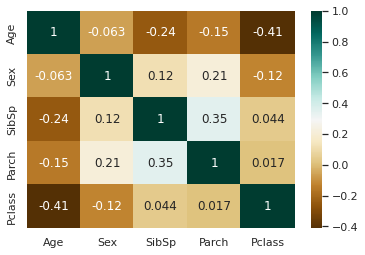

In [250]:
g = sns.heatmap(dataset[["Age","Sex","SibSp","Parch","Pclass"]].corr(), cmap='BrBG', annot=True)
# Age는 Sex와 관련이 없고, SibSp, Pclass, Parch와 음의 상관관계를 가짐.
# Age 결측치를 채우기 위해 SibSp, Parch, PClass를 사용함.

In [251]:
# Age의 결측치는 SibSp, Pclass, Parch값이 비슷한 행들의 중간값으로 채움.
index_NaN_age = list(dataset['Age'][dataset['Age'].isnull()].index)
for i in index_NaN_age:
  age_med = dataset['Age'].median()
  age_pred = dataset['Age'][((dataset['SibSp']==dataset.iloc[i]['SibSp'])&(dataset['Parch']==dataset.iloc[i]['Parch'])&(dataset['Pclass']==dataset.iloc[i]['Parch']))].median()
  if not np.isnan(age_pred):
    dataset['Age'].iloc[i] = age_pred
  else:
    dataset['Age'].iloc[i] = age_med

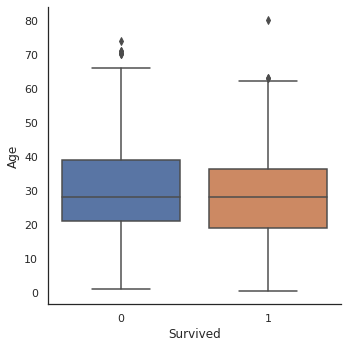

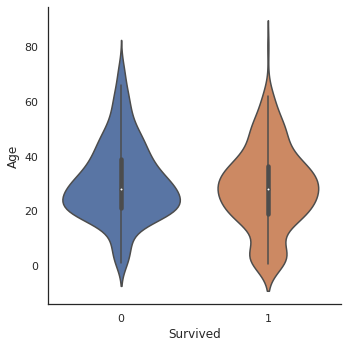

In [252]:
g = sns.factorplot(x='Survived', y='Age', data=train, kind='box')
g = sns.factorplot(x='Survived', y='Age', data=train, kind='violin')
# 매우 어린 승객들은 살아남을 확률이 더 높음.

# 5. Feature engineering

## 5.1 Name/Title

In [253]:
dataset['Name'].head()
# 가설: 유명한 사람이면 survived할 확률이 높음.

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [254]:
# Get Title from Name
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset['Name']] # strip(): 공백 제거
dataset["Title"] = pd.Series(dataset_title)
dataset["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

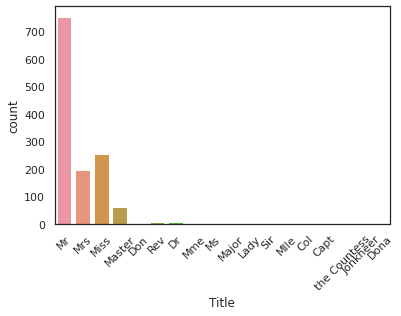

In [255]:
g = sns.countplot(x='Title', data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45)

In [256]:
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset['Title'].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset['Title'].astype(int)

In [257]:
dataset['Title']

0       2
1       1
2       1
3       1
4       2
       ..
1294    2
1295    3
1296    2
1297    2
1298    0
Name: Title, Length: 1299, dtype: int64

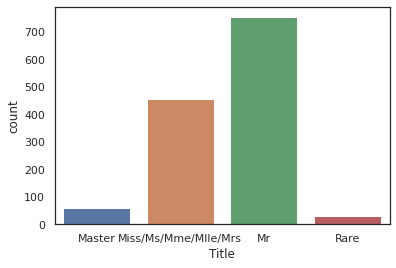

In [258]:
g = sns.countplot(dataset['Title'])
g = g.set_xticklabels(["Master","Miss/Ms/Mme/Mlle/Mrs","Mr","Rare"])

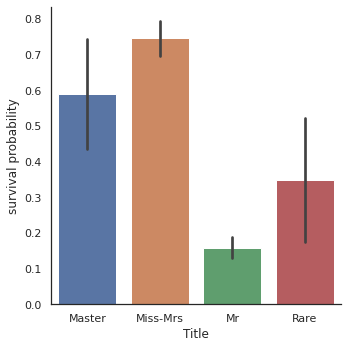

In [259]:
g = sns.factorplot(x='Title', y='Survived', data=dataset, kind='bar')
g = g.set_xticklabels(["Master","Miss-Mrs","Mr","Rare"])
g = g.set_ylabels('survival probability')
# "Women and children first"
# Miss-Mrs가 Survived할 확률이 높음.

In [260]:
dataset.drop(labels=['Name'], axis=1, inplace=True)

## 5.2 Family size

In [261]:
# 가설: Large family가 가족을 찾느라 구조되기 더 어려웠을 것임.
# 가족 수 변수 추가(Sibsp + Parch + 1(승객 자신))
dataset['Fsize'] = dataset["SibSp"] + dataset["Parch"] + 1

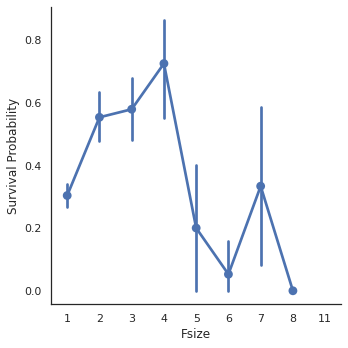

In [262]:
g = sns.factorplot(x='Fsize',y='Survived', data=dataset)
g = g.set_ylabels('Survival Probability')
# Survival probability is worst for large families.

In [263]:
# Create new feature of family size
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s==1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if  s == 2  else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)

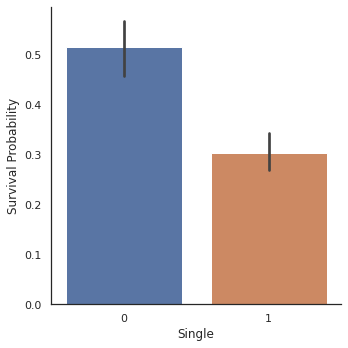

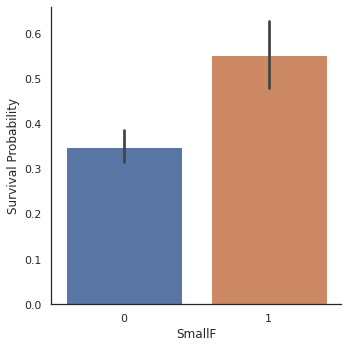

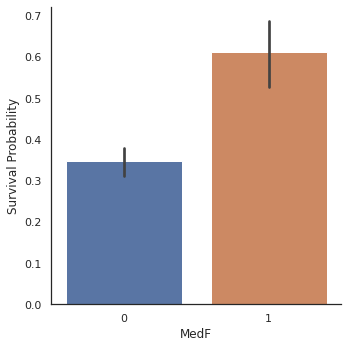

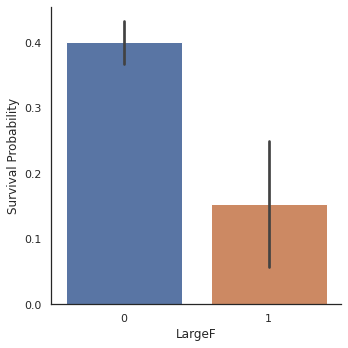

In [264]:
g = sns.factorplot(x='Single', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x='SmallF', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="MedF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="LargeF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
# Small and Medium families have more chance to survive than single passenger and large families.

In [265]:
dataset = pd.get_dummies(dataset, columns=['Title'])
dataset = pd.get_dummies(dataset, columns=['Embarked'], prefix="Em")

In [266]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,...,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,...,0,0,0,0,0,1,0,0,0,1


## 5.3 Cabin

In [267]:
dataset['Cabin'].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [268]:
dataset["Cabin"].describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [269]:
dataset["Cabin"].isnull().sum()

1007

In [270]:
dataset['Cabin'][dataset['Cabin'].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [271]:
# Replace the Cabin number by the type of cabin 'X' if not
dataset['Cabin'] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin']])

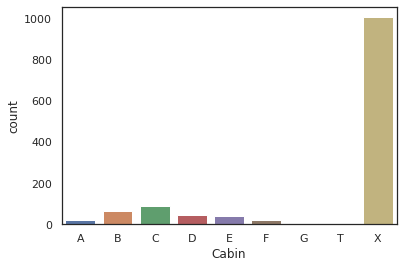

In [272]:
g = sns.countplot(dataset['Cabin'], order=['A','B','C','D','E','F','G','T','X'])

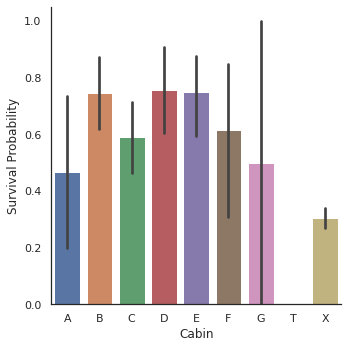

In [273]:
g = sns.factorplot(y='Survived', x='Cabin', data=dataset, kind='bar', order=['A','B','C','D','E','F','G','T','X'])
g = g.set_ylabels('Survival Probability')

In [274]:
dataset = pd.get_dummies(dataset, columns=['Cabin'], prefix='Cabin')

## 5.4 Ticket

In [275]:
dataset["Ticket"].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [276]:
# Tickets with same prefixes may have a similar class and survival.
# Treat Ticket by extracting the ticket prefix. When there is no prefix it returns X.
Ticket = []
for i in list(dataset.Ticket):
  if not i.isdigit():
    Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0])
  else:
    Ticket.append("X")
dataset['Ticket'] = Ticket
dataset['Ticket'].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [277]:
dataset = pd.get_dummies(dataset, columns=['Ticket'], prefix='T')

In [278]:
dataset['Pclass'] = dataset['Pclass'].astype('category')
dataset = pd.get_dummies(dataset, columns=['Pclass'], prefix="Pc")

In [279]:
dataset.drop(['PassengerId'], axis=1, inplace=True)

In [280]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1.0,1,35.0,1,0,3.972177,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,0.0,0,35.0,0,0,2.085672,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


# 6. MODELING

In [281]:
train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=['Survived'], axis=1, inplace=True)

In [282]:
train['Survived'] = train['Survived'].astype(int)
y_train = train['Survived']
X_train = train.drop(['Survived'], axis=1)

## 6.1 Simple modeling

### 6.1.1 Cross validate models

- SVC
- Decision Tree
- AdaBoost
- Random Forest
- Extra Trees
- Gradient Boosting
- Multiple layer perceprton (neural network)
- KNN
- Logistic regression
- Linear Discriminant Analysis

In [283]:
kfold = StratifiedKFold(n_splits=10)

random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers:
  cv_results.append(cross_val_score(classifier,X_train,y_train,scoring='accuracy',cv=kfold,n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,
                       "Algorithm":["SVC","DecisionTree","AdaBoost","RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

In [285]:
cv_res

,CrossValMeans,CrossValerrors,Algorithm
0,0.725358,0.044782,SVC
1,0.793463,0.039979,DecisionTree
2,0.795761,0.050925,AdaBoost
3,0.809295,0.045443,RandomForest
4,0.800281,0.047167,ExtraTrees
5,0.836555,0.043155,GradientBoosting
6,0.819535,0.036027,MultipleLayerPerceptron
7,0.797970,0.037882,KNeighboors
8,0.824068,0.036708,LogisticRegression
9,0.824068,0.040393,LinearDiscriminantAnalysis


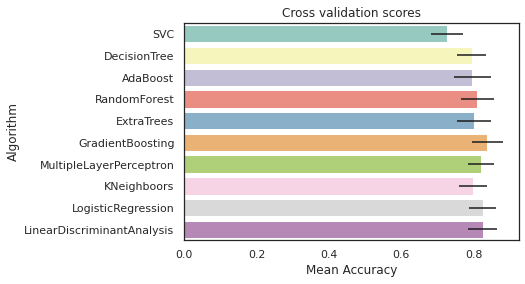

In [287]:
g = sns.barplot('CrossValMeans', 'Algorithm', data=cv_res, palette='Set3', orient="h", **{'xerr':cv_std}) # orient='h: horizontal
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

### 6.1.2 Hyperparameter tunning for best models

In [288]:
# Meta modeling: AdaBoost, RandomForest, ExtraTrees, GradientBoosting
DTC = DecisionTreeClassifier()
adaDTC = AdaBoostClassifier(DTC, random_state=7)
ada_param_grid = {'base_estimator__criterion':['gini','entropy'],
                  'base_estimator__splitter':['best','random'],
                  'n_estimators':[1,2],
                  'learning_rate':[0.0001,0.001,0.01,0.1, 0.2, 0.3, 1.5]}
gsadaDTC = GridSearchCV(adaDTC, param_grid = ada_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)
gsadaDTC.fit(X_train, y_train)
ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 56 candidates, totalling 560 fits


In [292]:
ada_best

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                         splitter='random'),
                   learning_rate=0.01, n_estimators=2, random_state=7)

In [291]:
gsadaDTC.best_score_

0.818449948927477

In [295]:
# ExtraTrees
ExtC = ExtraTreesClassifier()
ex_param_grid = {'max_depth':[None], 
                 'max_features':[1,3,10],
                 'min_samples_split':[2,3,10],
                 'min_samples_leaf':[1,3,10],
                 'bootstrap':[False],
                 'n_estimators':[100,300],
                 'criterion':['gini']}
gsExtC = GridSearchCV(ExtC, param_grid = ex_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)
gsExtC.fit(X_train, y_train)
ExtC_best = gsExtC.best_estimator_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


In [296]:
ExtC.best

ExtraTreesClassifier(max_features=3, min_samples_leaf=3, min_samples_split=3)

In [297]:
gsExtC.best_score_

0.8297497446373852

In [300]:
# RandomForest
RFC = RandomForestClassifier()
rf_param_grid = {'max_depth':[None],
                 'max_features':[1,3,10],
                 'min_samples_split':[2,3,10],
                 'min_samples_leaf':[1,3,10],
                 'bootstrap':[False],
                 'n_estimators':[100,300],
                 'criterion':['gini']}
gsRFC = GridSearchCV(RFC, param_grid = rf_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)
gsRFC.fit(X_train, y_train)
RFC_best = gsRFC.best_estimator_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


In [301]:
RFC_best

RandomForestClassifier(bootstrap=False, max_features=3, min_samples_leaf=3,
                       min_samples_split=3)

In [302]:
gsRFC.best_score_

0.8320097037793668

In [303]:
# GradientBoosting
GBC = GradientBoostingClassifier()
gb_param_grid = {'loss':['deviance'],
                 'n_estimators':[100,200,300],
                 'learning_rate':[0.1,0.05,0.01],
                 'max_depth':[4,8],
                 'min_samples_leaf':[100,150],
                 'max_features':[0.3,0.1]}
gsGBC = GridSearchCV(GBC, param_grid = gb_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)
gsGBC.fit(X_train, y_train)
GBC_best = gsGBC.best_estimator_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


In [304]:
GBC_best

GradientBoostingClassifier(max_depth=4, max_features=0.3, min_samples_leaf=100,
                           n_estimators=300)

In [305]:
gsGBC.best_score_

0.8297497446373852

In [306]:
# SVC
SVMC = SVC(probability=True)
svc_param_grid = {'kernel':['rbf'],
                  'gamma':[0.001,0.01,0.1,1],
                  'C':[1,10,50,100,200,300,1000]}
gsSVMC = GridSearchCV(SVMC, param_grid = svc_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)
gsSVMC.fit(X_train, y_train)
SVMC_best = gsSVMC.best_estimator_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


In [307]:
SBMC_best

SVC(C=10, gamma=0.01, probability=True)

In [308]:
gsSVMC.best_score_

0.8320224719101124

### 6.1.3 Plot learning curves

In [309]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(0.1,1,5)):
  plt.figure()
  plt.title(title)
  if ylim is not None:
    plt.ylim(*ylim)
  plt.xlabel("Training examples")
  plt.ylabel("Score")
  # 학습곡선
  train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
  traIn_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)
  plt.grid()
  plt.fill_between(train_sizes, traIn_scores_mean - train_scores_std, traIn_scores_mean + train_scores_std, alpha=0.1, color='r')
  plt.fill_between(train_sizes, test_scores_mean-test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
  plt.plot(train_sizes, traIn_scores_mean, 'o-', color='r', label='Training score')
  plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-Validation score')
  plt.legend(loc='best')
  return plt

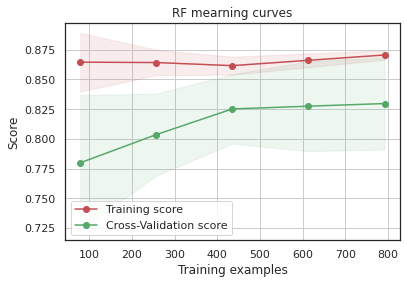

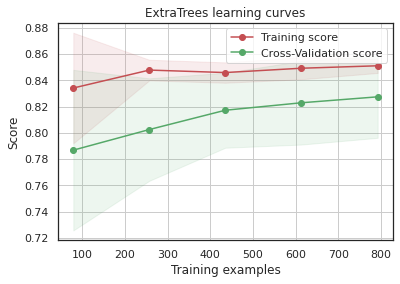

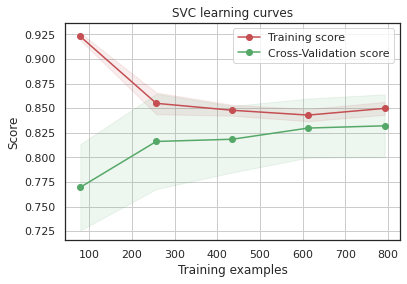

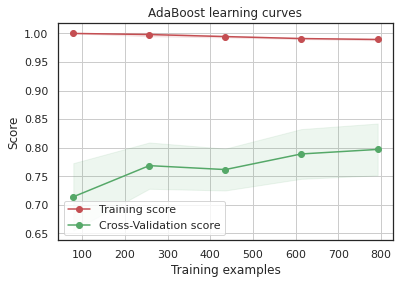

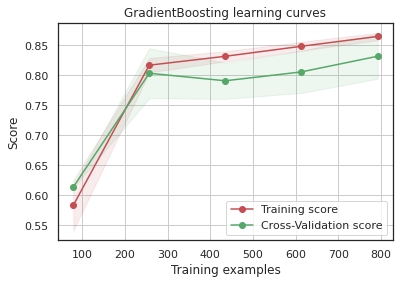

In [311]:
g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,y_train,cv=kfold)

- GradientBoosting and Adaboost classifiers tend to overfit the training set. According to the growing cross-validation curves GradientBoosting and Adaboost could perform better with more training examples.

- SVC and ExtraTrees classifiers seem to better generalize the prediction since the training and cross-validation curves are close together.

### 6.1.4 Feature importance of tree based classifiers

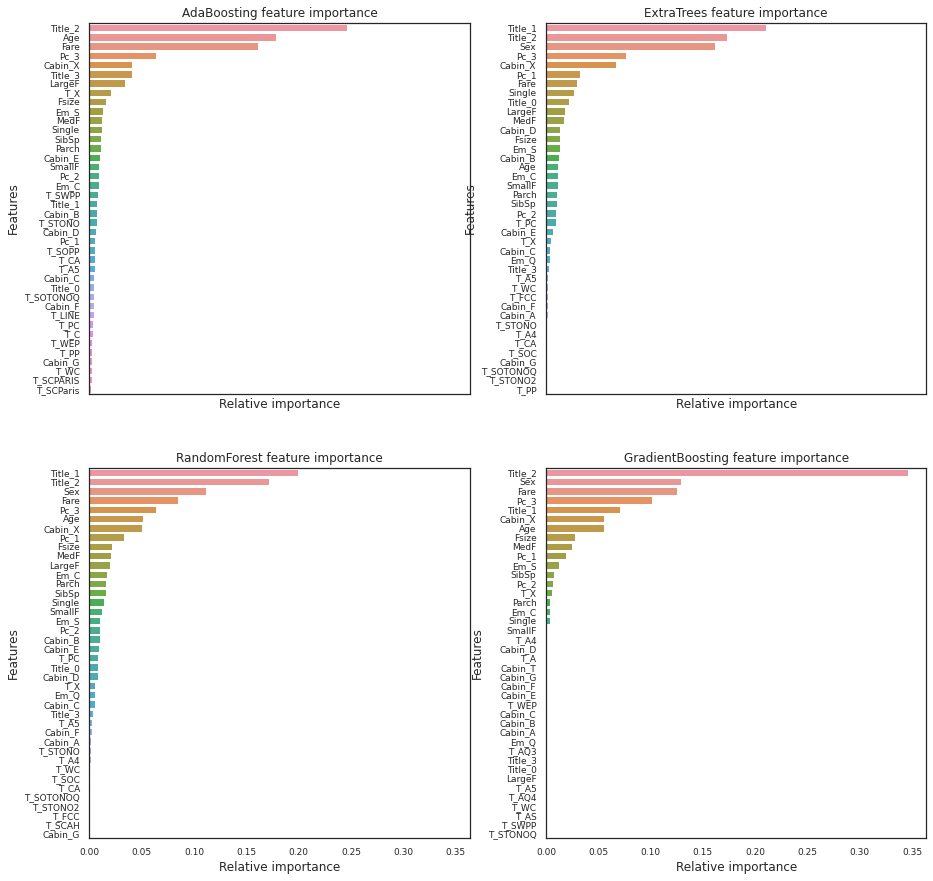

In [314]:
nrows = ncols = 2
fix, axes = plt.subplots(nrows=nrows, ncols = ncols, sharex='all', figsize=(15,15))
name_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

n_classifier = 0
for row in range(nrows):
  for col in range(ncols):
    name = name_classifiers[n_classifier][0]
    classifier = name_classifiers[n_classifier][1]
    indices = np.argsort(classifier.feature_importances_)[::-1][:40]
    
    g = sns.barplot(y=X_train.columns[indices][:40], x=classifier.feature_importances_[indices][:40], orient='h', ax=axes[row][col])
    g.set_xlabel("Relative importance",fontsize=12)
    g.set_ylabel("Features",fontsize=12)
    g.tick_params(labelsize=9)
    g.set_title(name + " feature importance")
    n_classifier += 1

- Pc_1, Pc_2, Pc_3 and Fare refer to the general social standing of passengers.

- Sex and Title_2 (Mrs/Mlle/Mme/Miss/Ms) and Title_3 (Mr) refer to the gender.

- Age and Title_1 (Master) refer to the age of passengers.

- Fsize, LargeF, MedF, Single refer to the size of the passenger family.

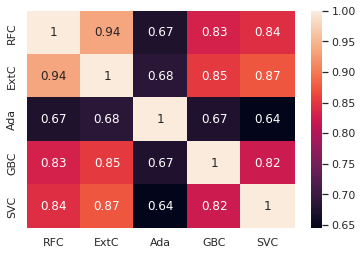

In [316]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name='RFC')
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")

ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC, test_Survived_SVMC], axis=1)

g = sns.heatmap(ensemble_results.corr(), annot=True)
# AdaBoost를 제외한 분류기들의 예측은 거의 비슷함.

## 6.2 Ensemble modeling

### 6.2.1 Combining models

In [317]:
votingC = VotingClassifier(estimators=[('rfc',RFC_best), ('extc',ExtC_best), ('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)],
                           voting='soft', n_jobs=4)
votingC = votingC.fit(X_train, y_train)

## 6.3 Prediction

### 6.3.1 Predict and Submit results

In [319]:
test_Survived = pd.Series(votingC.predict(test), name='Survived')
results = pd.concat([IDTest, test_Survived], axis=1)
results

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [ ]:
results.to_csv('ensemble_python_voting.csv', index=False)